# MFCC VS SWT1D
---

# Librerias

In [53]:
# =============================================================================
# Manejo de Archivos y Directorios
# =============================================================================
import os
import shutil
import zipfile

# =============================================================================
# Análisis y Manipulación de Datos
# =============================================================================
import pandas as pd
import numpy as np
from datetime import datetime

# =============================================================================
# Procesamiento y Análisis de Texto
# =============================================================================
import re

# =============================================================================
# Estadísticas y Muestreo
# =============================================================================
from scipy.stats import shapiro, norm, entropy
from sklearn.utils import resample

# =============================================================================
# Visualización de Datos
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# Procesamiento de Audio
# =============================================================================
from scipy.io import wavfile
import librosa
import librosa.display
from scipy.signal import spectrogram

# =============================================================================
# Generación de Números Aleatorios y Otros
# =============================================================================
import random
import requests

# =============================================================================
# Machine Learning
# =============================================================================
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import xgboost as xgb

# =============================================================================
# Deep Learning
# =============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# =============================================================================
# Scattering (Transformada Scattering1D)
# =============================================================================
# Nota: Ejecuta el comando de instalación de kymatio por separado en la terminal, no es parte de las importaciones.
# pip install kymatio
# from kymatio.numpy import Scattering1D as Scattering1D_numpy
from kymatio.sklearn import Scattering1D as Scattering1D

# Carga de Datos

In [54]:
# Función para descargar y extraer el archivo ZIP principal
def download_and_extract_zip(url, extract_to="extracted_data", date=''):
    zip_filename = f"data_{date}.zip"

    try:
        # Intentar descargar el archivo ZIP
        response = requests.get(url, stream=True, timeout=30)  # Agrega stream y timeout para mayor control

        if response.status_code == 200:
            # Guardar el archivo ZIP en el disco
            with open(zip_filename, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Archivo descargado correctamente: {zip_filename}")
        else:
            raise Exception(f"Error al descargar el archivo. Código de estado: {response.status_code}")

        # Crear el directorio de extracción si no existe
        os.makedirs(extract_to, exist_ok=True)

        # Intentar extraer el archivo ZIP
        with zipfile.ZipFile(zip_filename, "r") as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Archivos extraídos en '{extract_to}'")

    except requests.exceptions.RequestException as e:
        print(f"Error durante la descarga del archivo: {e}")

    except zipfile.BadZipFile:
        print(f"El archivo descargado no es un archivo ZIP válido: {zip_filename}")

    except Exception as e:
        print(f"Se produjo un error inesperado: {e}")

    finally:
        # Eliminar el archivo ZIP temporal si existe
        if os.path.exists(zip_filename):
            os.remove(zip_filename)
            print(f"Archivo temporal eliminado: {zip_filename}")

    return extract_to

# Función para extraer los ZIP internos y eliminar los ZIP originales después de extraer
def extract_inner_zips(folder):
    try:
        for root, _, files in os.walk(folder):
            for file in files:
                if file.endswith(".zip"):
                    zip_path = os.path.join(root, file)
                    extract_to = os.path.join(root, os.path.splitext(file)[0])

                    # Crear el directorio de extracción si no existe
                    os.makedirs(extract_to, exist_ok=True)

                    try:
                        # Intentar extraer el archivo ZIP interno
                        with zipfile.ZipFile(zip_path, "r") as zip_ref:
                            zip_ref.extractall(extract_to)
                        print(f"Extraído: {file} en {extract_to}")

                    except zipfile.BadZipFile:
                        print(f"El archivo ZIP interno no es válido: {zip_path}")

                    except Exception as e:
                        print(f"Error al extraer el archivo ZIP interno '{file}': {e}")

                    finally:
                        # Intentar eliminar el ZIP extraído
                        try:
                            os.remove(zip_path)
                            print(f"Eliminado archivo ZIP: {zip_path}")
                        except Exception as e:
                            print(f"Error al eliminar el archivo ZIP '{zip_path}': {e}")

    except Exception as e:
        print(f"Error al recorrer la carpeta '{folder}': {e}")

    finally:
        print("Proceso de extracción y limpieza de archivos internos completado.")

In [55]:
# Ejecutar las funciones
url = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/jwyy9np4gv-3.zip"

# Obtener la fecha actual en formato YYYY-MM-DD
current_date = datetime.now().strftime("%Y-%m-%d")
extract_to = f"extracted_data_{current_date}"
extracted_folder = download_and_extract_zip(url, extract_to, current_date)

# Extraer los ZIP internos
extract_inner_zips(extracted_folder)

Archivo descargado correctamente: data_2025-02-27.zip
Archivos extraídos en 'extracted_data_2025-02-27'
Archivo temporal eliminado: data_2025-02-27.zip
Extraído: Stethoscope Files.zip en extracted_data_2025-02-27/Stethoscope Files
Eliminado archivo ZIP: extracted_data_2025-02-27/Stethoscope Files.zip
Extraído: Audio Files.zip en extracted_data_2025-02-27/Audio Files
Eliminado archivo ZIP: extracted_data_2025-02-27/Audio Files.zip
Proceso de extracción y limpieza de archivos internos completado.


# Limpieza de Datos

In [56]:
# Definir el diccionario de mapeo
mapping = {
    "P": "Posterior",
    "L": ["Lower", "Left"],  # L puede ser Lower o Left dependiendo de la posición
    "R": "Right",
    "U": "Upper",
    "A": "Anterior",
    "M": "Middle",
    "I": "Inspiratory",
    "E": "Expiratory",
    "W": "Wheezes",
    "C": "Crackles",
    "N": "Normal",
    "Crep": "crepitations"
}

# Función para aplicar el mapeo
def map_string(value):
    # Dividir el string por espacios para separar las letras
    parts = value.split()

    mapped_parts = []

    for i, part in enumerate(parts):
        if part.upper() == "L":
            if i == 1:  # Si "L" está al principio, lo mapeamos como Left
                mapped_parts.append(mapping["L"][1])  # "Left"
            else:  # Si "L" está en otras posiciones, lo mapeamos como Lower
                mapped_parts.append(mapping["L"][0])  # "Lower"
        elif part in mapping:
            mapped_parts.append(mapping[part])
        else:
            mapped_parts.append(part)  # Si no está en el diccionario, dejamos la parte como está

    return " ".join(mapped_parts)

In [57]:
# Leer el archivo Excel
path = f'/content/extracted_data_{current_date}/Data annotation.xlsx'
df = pd.read_excel(path)

# Identificar y eliminar columnas con más del 90% de datos nulos
threshold = 0.90
columns_to_drop = df.columns[df.isnull().mean() > threshold]
df_cleaned = df.drop(columns=columns_to_drop)

# Mostrar las columnas eliminadas
print(f"\nColumnas eliminadas (más del {threshold*100}% de datos nulos):")
print(columns_to_drop.tolist())
print("="*40, "\n")

# Eliminar datos nulos
df_cleaned = df_cleaned.dropna()

# Asignar id
df_cleaned['id'] = df_cleaned.index + 1

# Preprocesar los datos: llenar valores nulos y limpiar texto, reemplazar las "n" por "normal", y llevar todo a minúsculas
df_cleaned['Diagnosis'] = df_cleaned['Diagnosis'].fillna("sin diagnóstico")
df_cleaned['Diagnosis'] = df_cleaned['Diagnosis'].apply(lambda word: re.sub(r'\bN\b', 'normal', word.strip(), flags=re.IGNORECASE))
df_cleaned['Diagnosis'] = df_cleaned['Diagnosis'].apply(lambda words: words.lower())

# Aplicar la función a la columna
df_cleaned['Location'] = df_cleaned['Location'].apply(map_string)
df_cleaned['Sound type'] = df_cleaned['Sound type'].apply(map_string)


Columnas eliminadas (más del 90.0% de datos nulos):
['Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Posterior: P Lower: L Left: L Right R, UPPER: U, ANTERIOR: A, MIDDLE: M']



# Modelos

Cargando audios y extrayendo características MFCC...

=== Experimentos MFCC ===

--- Experimento MFCC: MFCC KNN ---
MFCC KNN - Precisión: 65.27%
MFCC KNN - Mejores Parámetros: {'classifier__metric': 'cosine', 'classifier__n_neighbors': 4, 'classifier__weights': 'distance'}
MFCC KNN - Reporte de Clasificación:
                  precision    recall  f1-score   support

          asthma       0.69      0.64      0.66       153
            bron       0.46      0.55      0.50        11
            copd       0.51      0.52      0.52        44
   heart failure       0.61      0.58      0.59        79
   lung fibrosis       0.55      0.65      0.59        17
          normal       0.72      0.78      0.75       177
plueral effusion       0.62      0.53      0.57        15
       pneumonia       0.52      0.43      0.47        28

        accuracy                           0.65       524
       macro avg       0.58      0.58      0.58       524
    weighted avg       0.65      0.65      0.65  

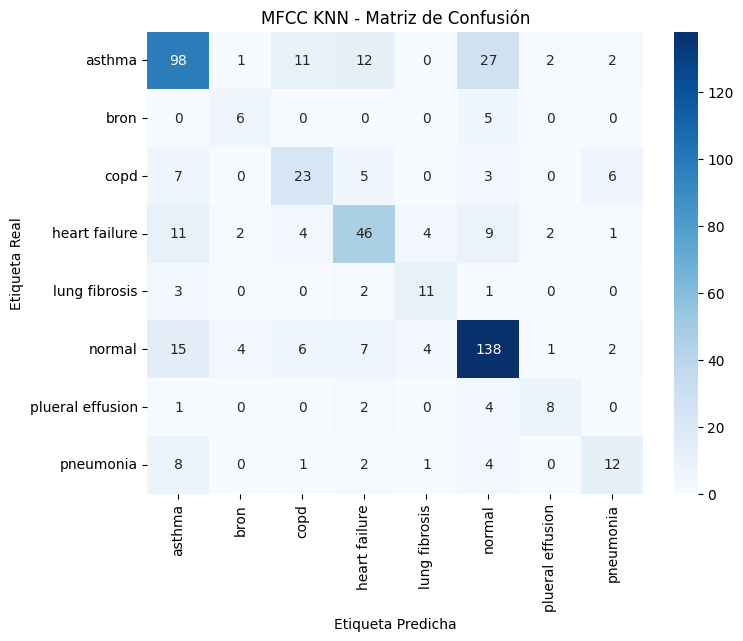

<ipython-input-60-bab244ea833e>:267: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


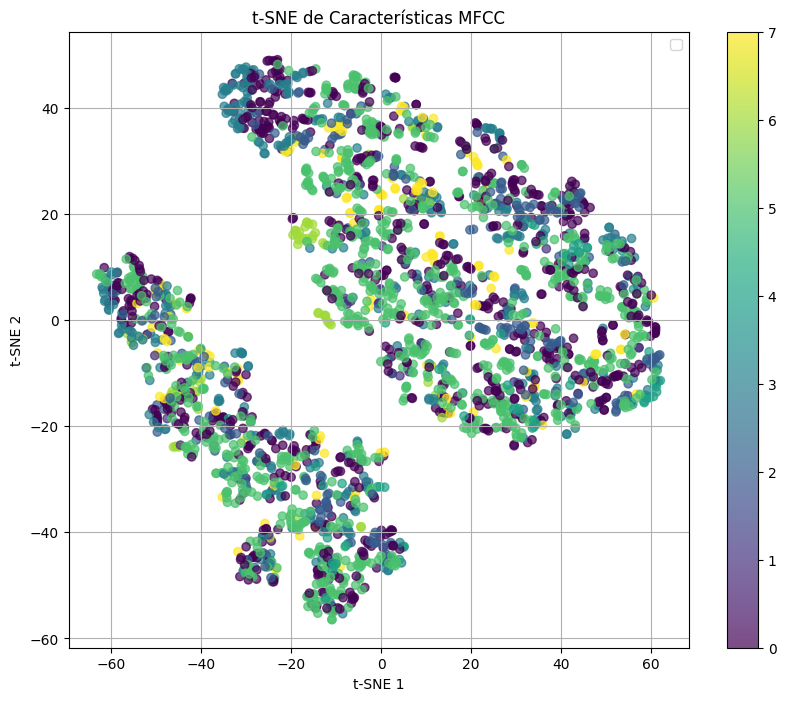


=== Experimentos SWT1D (Scattering1D) ===

--- Experimento SWT1D: Scattering KNN ---
Scattering KNN - Precisión: 95.04%
Scattering KNN - Reporte de Clasificación:
                  precision    recall  f1-score   support

          asthma       0.92      0.96      0.94       153
            bron       1.00      1.00      1.00        11
            copd       0.95      0.93      0.94        44
   heart failure       0.94      0.99      0.96        79
   lung fibrosis       1.00      1.00      1.00        17
          normal       0.97      0.91      0.94       177
plueral effusion       1.00      1.00      1.00        15
       pneumonia       0.93      1.00      0.97        28

        accuracy                           0.95       524
       macro avg       0.97      0.97      0.97       524
    weighted avg       0.95      0.95      0.95       524



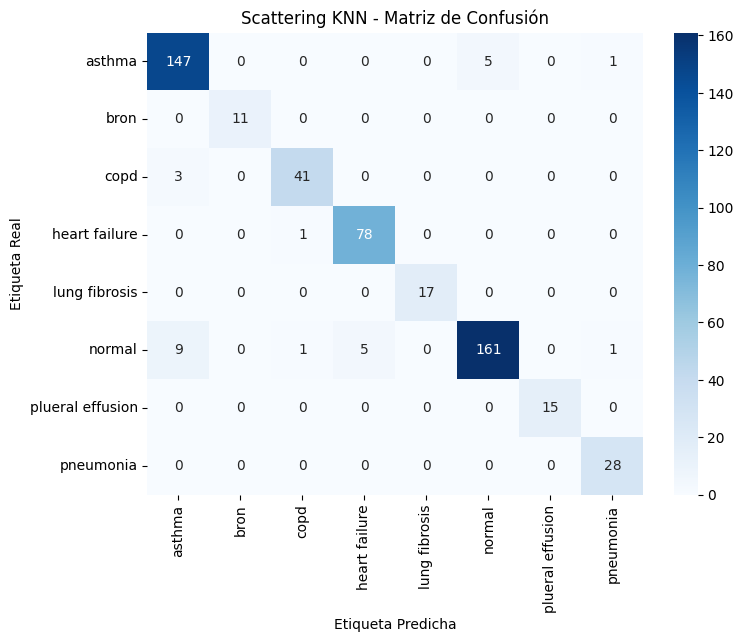

<ipython-input-60-bab244ea833e>:267: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


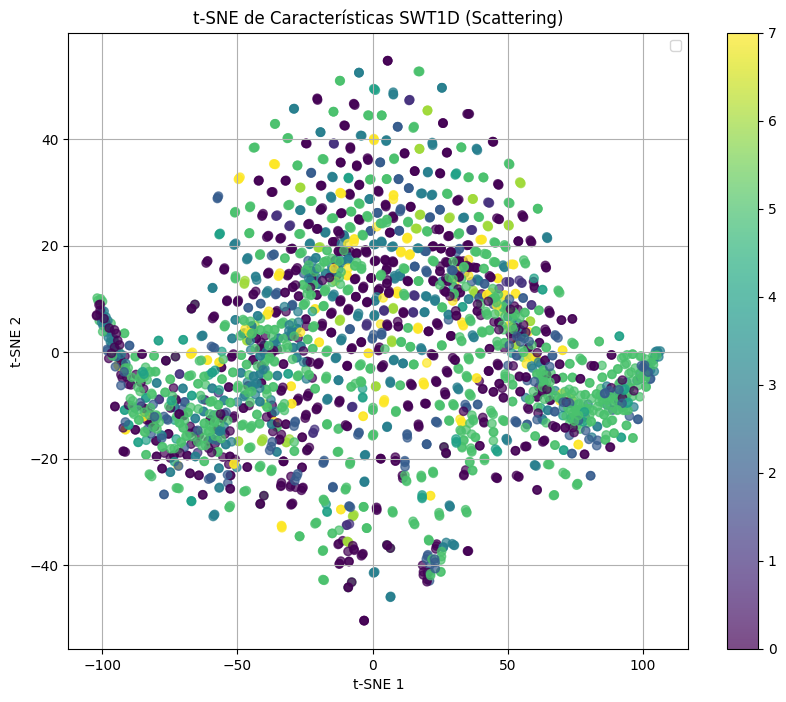

In [60]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

# Se requiere kymatio para la transformación Scattering1D
from kymatio.sklearn import Scattering1D

# ──────────────────────────────────────────────────────────────#
# Configuración Global y Mapeo de Filtros
# ──────────────────────────────────────────────────────────────#
ALPHABET_MAP = {
    'EP': 'Extended Mode Filtration',
    'DP': 'Diaphragm Mode Filtration',
    'BP': 'Bell Mode Filtration'
}

# ──────────────────────────────────────────────────────────────#
# 1. Funciones de Preprocesamiento y Extracción de Características (MFCC)
# ──────────────────────────────────────────────────────────────#
def segment_audio_fixed_length(audio_signal, sample_rate, segment_duration=2):
    """Segmenta la señal de audio en trozos de duración fija."""
    segment_samples = int(segment_duration * sample_rate)
    num_segments = len(audio_signal) // segment_samples
    segments = [audio_signal[i * segment_samples : i * segment_samples + segment_samples]
                for i in range(num_segments)]
    return segments

def extract_mfcc_features(segment, sample_rate, n_mfcc=13):
    """
    Extrae MFCCs y sus deltas a partir de un segmento.
    Retorna un diccionario con la media y desviación estándar de cada coeficiente.
    """
    features = {}
    mfcc = librosa.feature.mfcc(y=segment, sr=sample_rate, n_mfcc=n_mfcc)
    for i in range(mfcc.shape[0]):
        features[f'mfcc_{i+1}_mean'] = np.mean(mfcc[i, :])
        features[f'mfcc_{i+1}_std'] = np.std(mfcc[i, :])
    mfcc_delta = librosa.feature.delta(mfcc)
    for i in range(mfcc_delta.shape[0]):
        features[f'mfcc_delta_{i+1}_mean'] = np.mean(mfcc_delta[i, :])
        features[f'mfcc_delta_{i+1}_std'] = np.std(mfcc_delta[i, :])
    return features

def load_and_extract_mfcc_features(audio_folder_path, segment_duration=2):
    """
    Recorre la carpeta de audio, carga cada archivo WAV, lo segmenta y extrae
    las características MFCC (y sus deltas) de cada segmento.
    Retorna un DataFrame con la información y características.
    """
    records = []
    for root, _, files in os.walk(audio_folder_path):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                audio_signal, sample_rate = librosa.load(file_path, sr=None)
                segments = segment_audio_fixed_length(audio_signal, sample_rate, segment_duration)
                for segment in segments:
                    num_samples = len(segment)
                    duration_sec = num_samples / sample_rate
                    record = {
                        'id': int("".join(filter(str.isdigit, file.split("_")[0]))),
                        'filter': ALPHABET_MAP["".join(filter(str.isalpha, file.split("_")[0]))],
                        'path': file_path,
                        'sample_rate': sample_rate,
                        'audio_data': segment,
                        'duration_sec': duration_sec,
                        'num_samples': num_samples
                    }
                    mfcc_features = extract_mfcc_features(segment, sample_rate)
                    record.update(mfcc_features)
                    records.append(record)
    return pd.DataFrame(records)

def preprocess_mfcc_dataframe(wav_df, diagnosis_df):
    """
    Une el DataFrame de audio (wav_df) con el DataFrame de diagnóstico (diagnosis_df),
    filtra diagnósticos complejos y codifica la columna 'Diagnosis'.
    """
    merged_df = wav_df.merge(diagnosis_df, on='id', how='left').sort_values(by='id')
    # Se eliminan diagnósticos que contienen '+' o 'and'
    clean_diagnoses = [diag for diag in merged_df['Diagnosis'].unique() if ('+' not in diag and 'and' not in diag)]
    filtered_df = merged_df[merged_df['Diagnosis'].isin(clean_diagnoses)].copy()
    label_encoder = LabelEncoder()
    filtered_df['Diagnosis'] = label_encoder.fit_transform(filtered_df['Diagnosis'])
    if 'Gender' in filtered_df.columns:
        filtered_df['Gender'] = filtered_df['Gender'].map({'M': 0, 'F': 1})
    return filtered_df, label_encoder

def prepare_mfcc_features(df):
    """
    Prepara la matriz de características (X) y el vector objetivo (y) para el enfoque MFCC.
    Se eliminan columnas no relevantes.
    """
    drop_columns = ['id', 'path', 'audio_data', 'Diagnosis', 'filter', 'Location',
                    'Sound type', 'sample_rate', 'duration_sec', 'num_samples','Gender']
    X = df.drop(columns=drop_columns, errors='ignore')
    y = df['Diagnosis']
    return X, y

# ──────────────────────────────────────────────────────────────#
# 2. Funciones para Entrenamiento y Evaluación en MFCC (con GridSearchCV)
# ──────────────────────────────────────────────────────────────#
def run_model_gridsearch(X_train, y_train, X_test, y_test, label_encoder, classifier, param_grid, model_name="Modelo"):
    """
    Ejecuta GridSearchCV para un modelo dado, imprime métricas y grafica la matriz de confusión.
    """
    pipeline = Pipeline([
        # ('scaler', MinMaxScaler()),
        ('classifier', classifier)
    ])
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', return_train_score=True)
    grid_search.fit(X_train, y_train)

    y_pred = grid_search.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{model_name} - Precisión: {acc*100:.2f}%")
    print(f"{model_name} - Mejores Parámetros: {grid_search.best_params_}")
    print(f"{model_name} - Reporte de Clasificación:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_),
                annot=True, fmt='g', cmap='Blues')
    plt.title(f'{model_name} - Matriz de Confusión')
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.show()

    return grid_search

def run_mfcc_experiments_with_split(X_train, X_test, y_train, y_test, label_encoder):
    """
    Ejecuta experimentos MFCC para tres modelos (KNN, SVM, RandomForest) usando GridSearchCV.
    Retorna un diccionario con los resultados (grid_search) para extraer los mejores parámetros.
    """
    model_configs = {
        'MFCC KNN': {
            'model': KNeighborsClassifier(),
            'param_grid': {
                'classifier__n_neighbors': list(range(3, 8)),
                'classifier__weights': ['uniform', 'distance'],
                'classifier__metric': ['euclidean', 'cosine']
            }
        }
        # ,
        # 'MFCC SVM': {
        #     'model': SVC(probability=True),
        #     'param_grid': {
        #         'classifier__C': [0.1, 1, 10],
        #         'classifier__kernel': ['linear', 'rbf']
        #     }
        # },
        # 'MFCC RandomForest': {
        #     'model': RandomForestClassifier(),
        #     'param_grid': {
        #         'classifier__n_estimators': [50, 100, 150],
        #         'classifier__max_depth': [None, 10, 20],
        #         'classifier__min_samples_split': [2, 3, 5]
        #     }
        # }
    }

    results = {}
    for model_name, config in model_configs.items():
        print(f"\n--- Experimento MFCC: {model_name} ---")
        results[model_name] = run_model_gridsearch(
            X_train, y_train, X_test, y_test, label_encoder,
            config['model'], config['param_grid'], model_name=model_name
        )
    return results

# ──────────────────────────────────────────────────────────────#
# 3. Funciones para Experimentos con SWT1D (Scattering1D) sin GridSearchCV
# ──────────────────────────────────────────────────────────────#
def run_scattering_experiment(X_train_audio, X_test_audio, y_train, y_test, label_encoder,
                              J, Q, classifier_instance, model_name="Modelo"):
    """
    Construye y entrena un pipeline basado en Scattering1D usando el clasificador con los
    mejores hiperparámetros obtenidos en el caso MFCC. Evalúa el modelo y muestra las métricas.
    """
    input_length = X_train_audio.shape[1]
    pipeline = Pipeline([
        ('scattering', Scattering1D(J=J, Q=Q, shape=(input_length,), max_order=2)),
        # ('scaler', StandardScaler()),
        # ('pca', PCA(n_components=200)),
        ('classifier', classifier_instance)
    ])

    pipeline.fit(X_train_audio, y_train)
    y_pred = pipeline.predict(X_test_audio)
    acc = accuracy_score(y_test, y_pred)
    print(f"{model_name} - Precisión: {acc*100:.2f}%")
    print(f"{model_name} - Reporte de Clasificación:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_),
                annot=True, fmt='g', cmap='Blues')
    plt.title(f'{model_name} - Matriz de Confusión')
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.show()

    return pipeline

def run_scattering_experiments_with_split(X_train_audio, X_test_audio, y_train, y_test, label_encoder,
                                           J, Q, mfcc_results):
    """
    Para cada modelo probado en MFCC, utiliza los mejores hiperparámetros obtenidos
    para construir y evaluar un pipeline basado en Scattering1D sin GridSearchCV.
    """
    model_mapping = {
        'MFCC KNN': ('Scattering KNN', KNeighborsClassifier),
        'MFCC SVM': ('Scattering SVM', SVC),
        'MFCC RandomForest': ('Scattering RandomForest', RandomForestClassifier)
    }

    scattering_pipelines = {}

    for mfcc_model_name, grid_obj in mfcc_results.items():
        sc_model_name, clf_class = model_mapping[mfcc_model_name]
        best_params = {key.split("__")[1]: value for key, value in grid_obj.best_params_.items()}
        if clf_class == SVC and 'probability' not in best_params:
            best_params['probability'] = True
        clf_instance = clf_class(**best_params)

        print(f"\n--- Experimento SWT1D: {sc_model_name} ---")
        pipeline = run_scattering_experiment(
            X_train_audio, X_test_audio, y_train, y_test, label_encoder,
            J, Q, clf_instance, model_name=sc_model_name
        )
        scattering_pipelines[sc_model_name] = pipeline
    return scattering_pipelines

# ──────────────────────────────────────────────────────────────#
# Función para Visualizar t-SNE
# ──────────────────────────────────────────────────────────────#
def visualize_tsne(features, labels, title):
    """
    Reduce a 2D con t-SNE las características y genera un scatter plot
    coloreado según la etiqueta.
    """
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)
    plt.figure(figsize=(10,8))
    scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=labels, cmap='viridis', alpha=0.7)
    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.colorbar(scatter)
    plt.grid(True)
    plt.legend()
    plt.show()

# ──────────────────────────────────────────────────────────────#
# 4. Función Main: Ejecución de Experimentos y Visualizaciones
# ──────────────────────────────────────────────────────────────#
def main():
    # Definir la fecha (puede extraerse dinámicamente)
    current_date = "2025-02-26"  # Ejemplo
    audio_folder_path = f'/content/extracted_data_{current_date}/Audio Files'

    # Se asume que 'df_cleaned' ya está cargado con la información de diagnóstico.
    # Ejemplo: df_cleaned = pd.read_csv('diagnosis_data.csv')

    # ── Experimentos con MFCC ──#
    print("Cargando audios y extrayendo características MFCC...")
    mfcc_df = load_and_extract_mfcc_features(audio_folder_path, segment_duration=2)
    mfcc_df, mfcc_label_encoder = preprocess_mfcc_dataframe(mfcc_df, df_cleaned)
    mfcc_df = mfcc_df.reset_index(drop=True)

    # Preparamos los datos para MFCC
    X_mfcc, y_full = prepare_mfcc_features(mfcc_df)
    train_idx, test_idx = train_test_split(mfcc_df.index, test_size=0.2, random_state=42, stratify=mfcc_df['Diagnosis'])
    X_train_mfcc = X_mfcc.loc[train_idx]
    X_test_mfcc  = X_mfcc.loc[test_idx]
    y_train = y_full.loc[train_idx]
    y_test  = y_full.loc[test_idx]

    print("\n=== Experimentos MFCC ===")
    mfcc_results = run_mfcc_experiments_with_split(X_train_mfcc, X_test_mfcc, y_train, y_test, mfcc_label_encoder)

    # ── Visualización t-SNE para el espacio MFCC ──#
    # scaled_X_mfcc = MinMaxScaler().fit_transform(X_mfcc)
    visualize_tsne(X_mfcc, y_full, "t-SNE de Características MFCC")

    # ── Preparar datos para SWT1D (Scattering1D) ──#
    X_audio = np.stack(mfcc_df['audio_data'].values)
    X_train_audio = X_audio[train_idx]
    X_test_audio  = X_audio[test_idx]

    print("\n=== Experimentos SWT1D (Scattering1D) ===")
    scattering_results = run_scattering_experiments_with_split(
        X_train_audio, X_test_audio, y_train, y_test, mfcc_label_encoder,
        J=6, Q=8, mfcc_results=mfcc_results
    )

    # ── Visualización t-SNE para el espacio SWT1D ──#
    # Se extraen las características de scattering para todos los datos
    input_length = X_audio.shape[1]
    scattering_transformer = Scattering1D(J=6, Q=16, shape=(input_length,))
    scattering_features = scattering_transformer.transform(X_audio)
    # scaled_scattering = StandardScaler().fit_transform(scattering_features)
    visualize_tsne(scattering_features, y_full, "t-SNE de Características SWT1D (Scattering)")

if __name__ == "__main__":
    main()

# FIN
---

In [59]:
# import os
# import numpy as np
# import pandas as pd
# import librosa
# import matplotlib.pyplot as plt
# import seaborn as sns

# from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.decomposition import PCA
# from sklearn.pipeline import Pipeline

# # Se requiere kymatio para la transformación Scattering1D
# # from kymatio import Scattering1D
# from kymatio.sklearn import Scattering1D

# # ──────────────────────────────────────────────────────────────#
# # Configuración Global y Mapeo de Filtros
# # ──────────────────────────────────────────────────────────────#
# ALPHABET_MAP = {
#     'EP': 'Extended Mode Filtration',
#     'DP': 'Diaphragm Mode Filtration',
#     'BP': 'Bell Mode Filtration'
# }

# # ──────────────────────────────────────────────────────────────#
# # 1. Funciones de Preprocesamiento y Extracción de Características (MFCC)
# # ──────────────────────────────────────────────────────────────#
# def segment_audio_fixed_length(audio_signal, sample_rate, segment_duration=2):
#     """Segmenta la señal de audio en trozos de duración fija."""
#     segment_samples = int(segment_duration * sample_rate)
#     num_segments = len(audio_signal) // segment_samples
#     segments = [audio_signal[i * segment_samples : i * segment_samples + segment_samples]
#                 for i in range(num_segments)]
#     return segments

# def extract_mfcc_features(segment, sample_rate, n_mfcc=13):
#     """
#     Extrae MFCCs y sus deltas a partir de un segmento.
#     Retorna un diccionario con la media y desviación estándar de cada coeficiente.
#     """
#     features = {}
#     mfcc = librosa.feature.mfcc(y=segment, sr=sample_rate, n_mfcc=n_mfcc)
#     for i in range(mfcc.shape[0]):
#         features[f'mfcc_{i+1}_mean'] = np.mean(mfcc[i, :])
#         features[f'mfcc_{i+1}_std'] = np.std(mfcc[i, :])
#     mfcc_delta = librosa.feature.delta(mfcc)
#     for i in range(mfcc_delta.shape[0]):
#         features[f'mfcc_delta_{i+1}_mean'] = np.mean(mfcc_delta[i, :])
#         features[f'mfcc_delta_{i+1}_std'] = np.std(mfcc_delta[i, :])
#     return features

# def load_and_extract_mfcc_features(audio_folder_path, segment_duration=2):
#     """
#     Recorre la carpeta de audio, carga cada archivo WAV, lo segmenta y extrae
#     las características MFCC (y sus deltas) de cada segmento.
#     Retorna un DataFrame con la información y características.
#     """
#     records = []
#     for root, _, files in os.walk(audio_folder_path):
#         for file in files:
#             if file.endswith(".wav"):
#                 file_path = os.path.join(root, file)
#                 audio_signal, sample_rate = librosa.load(file_path, sr=None)
#                 segments = segment_audio_fixed_length(audio_signal, sample_rate, segment_duration)
#                 for segment in segments:
#                     num_samples = len(segment)
#                     duration_sec = num_samples / sample_rate
#                     record = {
#                         'id': int("".join(filter(str.isdigit, file.split("_")[0]))),
#                         'filter': ALPHABET_MAP["".join(filter(str.isalpha, file.split("_")[0]))],
#                         'path': file_path,
#                         'sample_rate': sample_rate,
#                         'audio_data': segment,
#                         'duration_sec': duration_sec,
#                         'num_samples': num_samples
#                     }
#                     mfcc_features = extract_mfcc_features(segment, sample_rate)
#                     record.update(mfcc_features)
#                     records.append(record)
#     return pd.DataFrame(records)

# def preprocess_mfcc_dataframe(wav_df, diagnosis_df):
#     """
#     Une el DataFrame de audio (wav_df) con el DataFrame de diagnóstico (diagnosis_df),
#     filtra diagnósticos complejos y codifica la columna 'Diagnosis'.
#     """
#     merged_df = wav_df.merge(diagnosis_df, on='id', how='left').sort_values(by='id')
#     # Se eliminan diagnósticos que contienen '+' o 'and'
#     clean_diagnoses = [diag for diag in merged_df['Diagnosis'].unique() if ('+' not in diag and 'and' not in diag)]
#     filtered_df = merged_df[merged_df['Diagnosis'].isin(clean_diagnoses)].copy()
#     label_encoder = LabelEncoder()
#     filtered_df['Diagnosis'] = label_encoder.fit_transform(filtered_df['Diagnosis'])
#     if 'Gender' in filtered_df.columns:
#         filtered_df['Gender'] = filtered_df['Gender'].map({'M': 0, 'F': 1})
#     return filtered_df, label_encoder

# def prepare_mfcc_features(df):
#     """
#     Prepara la matriz de características (X) y el vector objetivo (y) para el enfoque MFCC.
#     Se eliminan columnas no relevantes.
#     """
#     drop_columns = ['id', 'path', 'audio_data', 'Diagnosis', 'filter', 'Location',
#                     'Sound type', 'sample_rate', 'duration_sec', 'num_samples','Gender']
#     X = df.drop(columns=drop_columns, errors='ignore')
#     y = df['Diagnosis']
#     return X, y

# # ──────────────────────────────────────────────────────────────#
# # 2. Funciones para Entrenamiento y Evaluación en MFCC (con GridSearchCV)
# # ──────────────────────────────────────────────────────────────#
# def run_model_gridsearch(X_train, y_train, X_test, y_test, label_encoder, classifier, param_grid, model_name="Modelo"):
#     """
#     Ejecuta GridSearchCV para un modelo dado, imprime métricas y grafica la matriz de confusión.
#     """
#     pipeline = Pipeline([
#         ('scaler', MinMaxScaler()),
#         ('classifier', classifier)
#     ])
#     grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', return_train_score=True)
#     grid_search.fit(X_train, y_train)

#     y_pred = grid_search.predict(X_test)
#     acc = accuracy_score(y_test, y_pred)
#     print(f"{model_name} - Precisión: {acc*100:.2f}%")
#     print(f"{model_name} - Mejores Parámetros: {grid_search.best_params_}")
#     print(f"{model_name} - Reporte de Clasificación:")
#     print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

#     cm = confusion_matrix(y_test, y_pred)
#     plt.figure(figsize=(8,6))
#     sns.heatmap(pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_),
#                 annot=True, fmt='g', cmap='Blues')
#     plt.title(f'{model_name} - Matriz de Confusión')
#     plt.ylabel('Etiqueta Real')
#     plt.xlabel('Etiqueta Predicha')
#     plt.show()

#     return grid_search

# def run_mfcc_experiments_with_split(X_train, X_test, y_train, y_test, label_encoder):
#     """
#     Ejecuta experimentos MFCC para tres modelos (KNN, SVM, RandomForest) usando GridSearchCV.
#     Retorna un diccionario con los resultados (grid_search) para extraer los mejores parámetros.
#     """
#     model_configs = {
#         'MFCC KNN': {
#             'model': KNeighborsClassifier(),
#             'param_grid': {
#                 'classifier__n_neighbors': list(range(3, 16)),
#                 'classifier__weights': ['uniform', 'distance'],
#                 'classifier__metric': ['euclidean', 'cosine']
#             }
#         },
#         'MFCC SVM': {
#             'model': SVC(probability=True),
#             'param_grid': {
#                 'classifier__C': [0.1, 1, 10],
#                 'classifier__kernel': ['linear', 'rbf']
#             }
#         },
#         'MFCC RandomForest': {
#             'model': RandomForestClassifier(),
#             'param_grid': {
#                 'classifier__n_estimators': [50, 100, 200],
#                 'classifier__max_depth': [None, 10, 20]
#             }
#         }
#     }

#     results = {}
#     for model_name, config in model_configs.items():
#         print(f"\n--- Experimento MFCC: {model_name} ---")
#         results[model_name] = run_model_gridsearch(
#             X_train, y_train, X_test, y_test, label_encoder,
#             config['model'], config['param_grid'], model_name=model_name
#         )
#     return results

# # ──────────────────────────────────────────────────────────────#
# # 3. Funciones para Experimentos con SWT1D (Scattering1D) sin GridSearchCV
# # ──────────────────────────────────────────────────────────────#
# def run_scattering_experiment(X_train_audio, X_test_audio, y_train, y_test, label_encoder,
#                               J, Q, classifier_instance, model_name="Modelo"):
#     """
#     Construye y entrena un pipeline basado en Scattering1D usando el clasificador con los
#     mejores hiperparámetros obtenidos en el caso MFCC. Evalúa el modelo y muestra las métricas.
#     """
#     input_length = X_train_audio.shape[1]
#     pipeline = Pipeline([
#         ('scattering', Scattering1D(J=J, Q=Q, shape=(input_length,))),
#         # ('scaler', StandardScaler()),
#         # ('pca', PCA(n_components=0.9)),
#         # ('scaler', MinMaxScaler()),
#         ('classifier', classifier_instance)
#     ])

#     pipeline.fit(X_train_audio, y_train)
#     y_pred = pipeline.predict(X_test_audio)
#     acc = accuracy_score(y_test, y_pred)
#     print(f"{model_name} - Precisión: {acc*100:.2f}%")
#     print(f"{model_name} - Reporte de Clasificación:")
#     print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

#     cm = confusion_matrix(y_test, y_pred)
#     plt.figure(figsize=(8,6))
#     sns.heatmap(pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_),
#                 annot=True, fmt='g', cmap='Blues')
#     plt.title(f'{model_name} - Matriz de Confusión')
#     plt.ylabel('Etiqueta Real')
#     plt.xlabel('Etiqueta Predicha')
#     plt.show()

#     return pipeline

# def run_scattering_experiments_with_split(X_train_audio, X_test_audio, y_train, y_test, label_encoder,
#                                            J, Q, mfcc_results):
#     """
#     Para cada modelo probado en MFCC, utiliza los mejores hiperparámetros obtenidos
#     para construir y evaluar un pipeline basado en Scattering1D sin GridSearchCV.
#     """
#     # Diccionario para mapear los nombres de los modelos MFCC a los correspondientes en SWT1D.
#     model_mapping = {
#         'MFCC KNN': ('Scattering KNN', KNeighborsClassifier),
#         'MFCC SVM': ('Scattering SVM', SVC),
#         'MFCC RandomForest': ('Scattering RandomForest', RandomForestClassifier)
#     }

#     scattering_pipelines = {}

#     for mfcc_model_name, grid_obj in mfcc_results.items():
#         sc_model_name, clf_class = model_mapping[mfcc_model_name]
#         # Extraer los parámetros optimizados; se quita el prefijo "classifier__"
#         best_params = {key.split("__")[1]: value for key, value in grid_obj.best_params_.items()}
#         # Para SVC, asegurar que probability esté activado
#         if clf_class == SVC and 'probability' not in best_params:
#             best_params['probability'] = True
#         clf_instance = clf_class(**best_params)

#         print(f"\n--- Experimento SWT1D: {sc_model_name} ---")
#         pipeline = run_scattering_experiment(
#             X_train_audio, X_test_audio, y_train, y_test, label_encoder,
#             J, Q, clf_instance, model_name=sc_model_name
#         )
#         scattering_pipelines[sc_model_name] = pipeline
#     return scattering_pipelines

# # ──────────────────────────────────────────────────────────────#
# # 4. Función Main: Ejecución de Experimentos
# # ──────────────────────────────────────────────────────────────#
# def main():
#     # Definir la fecha (puede extraerse dinámicamente)
#     current_date = "2025-02-26"  # Ejemplo
#     audio_folder_path = f'/content/extracted_data_{current_date}/Audio Files'

#     # Se asume que 'df_cleaned' ya está cargado con la información de diagnóstico
#     # Ejemplo: df_cleaned = pd.read_csv('diagnosis_data.csv')

#     # ── Experimentos con MFCC ──#
#     print("Cargando audios y extrayendo características MFCC...")
#     mfcc_df = load_and_extract_mfcc_features(audio_folder_path, segment_duration=2)
#     mfcc_df, mfcc_label_encoder = preprocess_mfcc_dataframe(mfcc_df, df_cleaned)
#     # Reseteamos el índice para mantener el orden y usar el mismo split en ambos enfoques
#     mfcc_df = mfcc_df.reset_index(drop=True)

#     # Preparamos los datos para MFCC
#     X_mfcc, y_full = prepare_mfcc_features(mfcc_df)
#     # Generamos índices de train/test usando la columna 'Diagnosis'
#     train_idx, test_idx = train_test_split(mfcc_df.index, test_size=0.2, random_state=42, stratify=mfcc_df['Diagnosis'])
#     X_train_mfcc = X_mfcc.loc[train_idx]
#     X_test_mfcc  = X_mfcc.loc[test_idx]
#     y_train = y_full.loc[train_idx]
#     y_test  = y_full.loc[test_idx]

#     print("\n=== Experimentos MFCC ===")
#     mfcc_results = run_mfcc_experiments_with_split(X_train_mfcc, X_test_mfcc, y_train, y_test, mfcc_label_encoder)

#     # ── Preparar datos para SWT1D (Scattering1D) ──#
#     # Utilizar la misma división para comparar ambos enfoques
#     X_audio = np.stack(mfcc_df['audio_data'].values)
#     X_train_audio = X_audio[train_idx]
#     X_test_audio  = X_audio[test_idx]

#     print("\n=== Experimentos SWT1D (Scattering1D) ===")
#     # Usar los mejores hiperparámetros obtenidos en MFCC para instanciar los clasificadores
#     scattering_results = run_scattering_experiments_with_split(
#         X_train_audio, X_test_audio, y_train, y_test, mfcc_label_encoder,
#         J=6, Q=16, mfcc_results=mfcc_results
#     )

# if __name__ == "__main__":
#     main()
